### Imports

In [666]:
import os
import numpy as np
import trimesh
import random
import math
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import keras.models

from PIL import Image
from random import seed
from random import random
from sklearn.decomposition import PCA

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import keyboard
import seaborn as sns

### Read data

In [260]:
start = 1

In [264]:
def read_off(file):
    return trimesh.load(file).sample(8192)


def plot3D(data, save):
    global start
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(data[:, 0], data[:, 1], data[:, 2])
    ax.view_init(30, 200)
    if save:
        start += 1
        plt.savefig('images/' + str(start) + '.png')

def plot2DBW(data, save):
    global start
    plt.imshow(data[1],'gray')
    if save:
        start += 1
        plt.savefig('images/' + str(start) + '.png')
    plt.show()

In [252]:

files_train = os.listdir(path + 'chair' + "/train")

i = 0

for f in files_train:
    print(str(i) + " " + str(f))
    i += 1

0 chair_0292.off
1 chair_0603.off
2 chair_0098.off
3 chair_0803.off
4 chair_0331.off
5 chair_0580.off
6 chair_0420.off
7 chair_0409.off
8 chair_0315.off
9 chair_0285.off
10 chair_0018.off
11 chair_0125.off
12 chair_0451.off
13 chair_0425.off
14 chair_0242.off
15 chair_0606.off
16 chair_0255.off
17 chair_0769.off
18 chair_0849.off
19 chair_0640.off
20 chair_0762.off
21 chair_0032.off
22 chair_0517.off
23 chair_0245.off
24 chair_0369.off
25 chair_0504.off
26 chair_0110.off
27 chair_0262.off
28 chair_0365.off
29 chair_0567.off
30 chair_0714.off
31 chair_0116.off
32 chair_0850.off
33 chair_0014.off
34 chair_0367.off
35 chair_0186.off
36 chair_0623.off
37 chair_0586.off
38 chair_0824.off
39 chair_0460.off
40 chair_0299.off
41 chair_0598.off
42 chair_0697.off
43 chair_0826.off
44 chair_0020.off
45 chair_0660.off
46 chair_0056.off
47 chair_0424.off
48 chair_0495.off
49 chair_0398.off
50 chair_0791.off
51 chair_0179.off
52 chair_0079.off
53 chair_0140.off
54 chair_0224.off
55 chair_0337.off
56

In [3]:
categories = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]

train_data = []
test_data = []

path = './ModelNet10/'

current = 0

for category in categories:

    files_train = os.listdir(path + category + "/train")

    for f in files_train:
        train_data.append((category, read_off(path + category + "/train/" + f)))
        current += 1
        if current % 100 == 0:
            print(current)

    files_test = os.listdir(path + category + "/test")

    for f in files_test:
        test_data.append((category, read_off(path + category + "/test/" + f)))
        current += 1
        if current % 100 == 0:
            print(current)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


### Normalize

In [36]:
def normalize(train_data):
    current = 0
    normalizedSize = 240
    new_train_data = []

    maxXReal = 0
    maxYReal = 0
    maxZReal = 0

    for model in train_data:
        minX = 123123123
        minY = 123123123
        minZ = 123123123
        maxX = -123123123
        maxY = -123123123
        maxZ = -123123123

        for point in model[1]:
            minX = min(minX, point[0])
            minY = min(minY, point[1])
            minZ = min(minZ, point[2])
            maxX = max(maxX, point[0])
            maxY = max(maxY, point[1])
            maxZ = max(maxZ, point[2])

        result = []

        if maxX - minX >= maxY - minY and maxX - minX >= maxZ - minZ:
            divRatio = maxX - minX
        elif maxY - minY >= maxX - minX and maxY - minY >= maxZ - minZ:
            divRatio = maxY - minY
        else:
            divRatio = maxZ - minZ

        for point in model[1]:
            newX = ((point[0] - minX) / divRatio) * normalizedSize
            newY = ((point[1] - minY) / divRatio) * normalizedSize
            # !!!!!!!!!!!!!!!!!                                                                  NORMALIZATION FOR EVERY AXIS OF THE
            newZ = ((point[2] - minZ) / (maxZ - minZ)) * normalizedSize

            maxXReal = max(maxXReal, newX)
            maxYReal = max(maxYReal, newY)
            maxZReal = max(maxZReal, newZ)

            result.append(np.array([newX, newY, newZ]))

        new_train_data.append((model[0], np.array(result)))

        current += 1

        if current % 100 == 0:
            print(current)

        # print(str(minX) + " + " + str(maxX))
    return new_train_data

In [37]:
train_data_n = normalize(train_data)
test_data_n = normalize(test_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


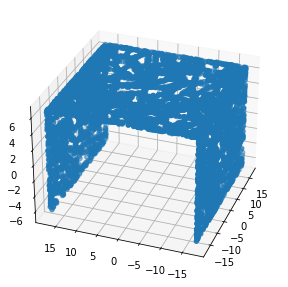

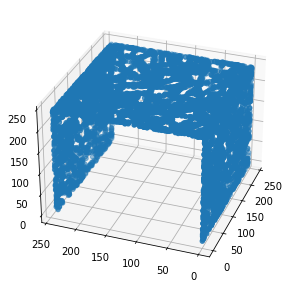

In [325]:
index = 3508
plot3D(train_data[index][1], False)
plot3D(train_data_n[index][1], False)

### Process the data ( 2D simple slicing )

In [266]:
def changeView(data):
    current = 0
    normalizedSize = 240
    images = []

    for model in data:
        slices = np.zeros((normalizedSize*4, normalizedSize*4), 'uint8')
        for point in model[1]:
            point_slice = int((point[2] - 0.001) / 15)
            i = int(point_slice / 4)
            j = int(point_slice % 4)
            targetI = int(point[0] - 0.01 + i * normalizedSize)
            targetJ = int(point[1] - 0.01 + j * normalizedSize)
            for nextI in range(3):
                for nextJ in range(3):
                    goI = targetI + nextI - 1
                    goJ = targetJ + nextJ - 1

                    if goI < 0 or goI >= 4*normalizedSize or goJ < 0 or goJ >= 4*normalizedSize:
                        continue

                    slices[goI, goJ] = 1
        images.append((model[0], slices))
        current += 1
        if current % 100 == 0:
            print(current)

    return images

In [42]:
train_images = changeView(train_data_n)
test_images = changeView(test_data_n)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


In [92]:
start = 0

140


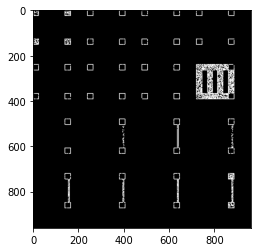

In [235]:
start += 1
print(start)
plot2DBW(train_images[661 + start], False, start)

### Process the data ( 2D multiaxis slicing )

In [268]:
def changeViewRGB(data):
    current = 0
    normalizedSize = 80
    images = []

    for model in data:
        slices = np.zeros((3, normalizedSize, normalizedSize, 3), 'uint8')
        for point in model[1]:
            point_slice_x = int((point[0] - 0.001) / 20)
            point_slice_y = int((point[1] - 0.001) / 20)
            point_slice_z = int((point[2] - 0.001) / 20)
            i = int(point_slice_x / 4)
            j = int(point_slice_y / 4)
            k = int(point_slice_z / 4)

            goI = int((point[0] - 0.001)/3)
            goJ = int((point[1] - 0.001)/3)

            if 0 <= goI < normalizedSize and 0 <= goJ < normalizedSize:
                slices[0, goI, goJ, k] += (256 - slices[0, goI, goJ, k])/2

            goI = int((point[0] - 0.001)/3)
            goJ = int((point[2] - 0.001)/3)

            if 0 <= goI < normalizedSize and 0 <= goJ < normalizedSize:
                slices[1, goI, goJ, j] += (256 - slices[1, goI, goJ, j])/2

            goI = int((point[1] - 0.001)/3)
            goJ = int((point[2] - 0.001)/3)

            if 0 <= goI < normalizedSize and 0 <= goJ < normalizedSize:
                slices[2, goI, goJ, i] += (256 - slices[2, goI, goJ, i])/2

            #slices[int(point[0] - 0.01), int(point[1] - 0.01), i] |= (3 << (2 * j))


        images.append((model[0], slices))
        current += 1
        if current % 100 == 0:
            print(current)

    return images

In [269]:
train_images_rgb = changeViewRGB(train_data_n)
test_images_rgb = changeViewRGB(test_data_n)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


In [270]:
def combineToSinglePicture(data):
    images = []
    normalizedSize = 80
    padding = int(0)
    for image in data:
        slices = np.zeros((normalizedSize, normalizedSize*3 + padding*2, 3), 'uint8')
        slices[:, 0:normalizedSize,:] = image[1][0,:,:]
        slices[:, normalizedSize + padding:2*normalizedSize + padding,:] = image[1][1,:,:]
        slices[:, 2*normalizedSize + padding*2: 3*normalizedSize + padding*2,:] = image[1][2,:,:]
        images.append((image[0], slices))
    return images

In [271]:
train_images_rgb_combined = combineToSinglePicture(train_images_rgb)
test_images_rgb_combined = combineToSinglePicture(test_images_rgb)

toilet


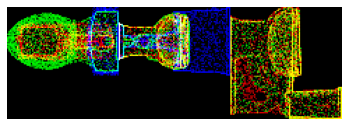

In [348]:
index = 3701
print(train_images_rgb_combined[index][0])

plt.imshow(train_images_rgb_combined[index][1])
plt.axis('off')
plt.savefig('images/' + str(10) + '.png')
plt.show()

### Prepare to feed to the model

In [349]:
train_final = np.array([i[1] for i in train_images_rgb_combined])
train_labels = np.array([categories.index(l) for l in [i[0] for i in train_images_rgb_combined]])

In [350]:
test_final = np.array([i[1] for i in test_images_rgb_combined])
test_labels = np.array([categories.index(l) for l in [i[0] for i in test_images_rgb_combined]])

In [351]:
train_final[0].shape

(80, 240, 3)

### The Model

In [359]:
# model = tf.keras.Sequential([
#     # tf.keras.layers.Conv2D(60, kernel_size=(3, 3), input_shape=(240*4, 240*4, 1)),
#     # tf.keras.layers.MaxPool2D(pool_size=(8, 8)),
#     # tf.keras.layers.Conv2D(60, kernel_size=(3, 3)),
#     # tf.keras.layers.MaxPool2D(pool_size=(8, 8)), # !!! 2 2
#     tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dropout(0.7),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
#     #tf.keras.layers.Dropout(0.5),
#     #tf.keras.layers.Dense(512, activation='relu'),
#     #tf.keras.layers.Dropout(0.5),
#     #tf.keras.layers.Dense(256, activation='relu'),
#     #tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])
#
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=2, input_shape=(80, 240, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(80, kernel_size=2),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(160, kernel_size=2),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(320, kernel_size=2),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
model.fit(train_final, train_labels, epochs=6)

test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

#### Step by step fit

In [360]:
losses_2 = []
accs_2 = []

In [361]:
minutes_to_do = 10

i = 0

import time

def current_milli_time():
    return round(time.time() * 1000)

current_time = current_milli_time()

while i <= 100:
    i += 1
    print(i)
    print(train_final.shape, train_labels.shape)
    model.fit(train_final, train_labels, epochs=1)
    test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)
    losses_2.append(test_loss)
    accs_2.append(test_acc)
    print('Test accuracy:', test_acc, '\n')

1
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 12s 95ms/step - loss: 3.5521 - accuracy: 0.7715
29/29 - 1s - loss: 0.6198 - accuracy: 0.8161 - 1s/epoch - 38ms/step
Test accuracy: 0.816079318523407 

2
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 12s 93ms/step - loss: 0.2695 - accuracy: 0.9143
29/29 - 1s - loss: 0.5735 - accuracy: 0.8535 - 983ms/epoch - 34ms/step
Test accuracy: 0.8535242080688477 

3
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 12s 93ms/step - loss: 0.2515 - accuracy: 0.9243
29/29 - 1s - loss: 0.6187 - accuracy: 0.8579 - 971ms/epoch - 33ms/step
Test accuracy: 0.857929527759552 

4
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 12s 92ms/step - loss: 0.1600 - accuracy: 0.9494
29/29 - 1s - loss: 0.7985 - accuracy: 0.8403 - 957ms/epoch - 33ms/step
Test accuracy: 0.8403083682060242 

5
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 12s 95ms/step - loss: 0.1

In [ ]:
test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)
print('Test accuracy:', test_acc, '\n')

In [ ]:
accs_2 = [0] + [0.5] + [0.75] + accs_2

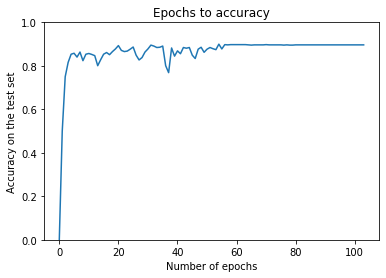

In [400]:
plt.title("Epochs to accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy on the test set")
plt.ylim([0, 1])
plt.plot(accs_2)
plt.savefig('images/accuracy.png')
plt.show()

In [403]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 79, 239, 64)       832       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 79, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 78, 80)        20560     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 8, 26, 80)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 25, 160)        51360     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 3, 12, 160)      

In [545]:
y_pred = model.predict(test_final)

In [637]:
y_pred_actual = np.argmax(y_pred, axis=1)
print(test_labels)
print(y_pred_actual)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 

In [ ]:
current = 265
plt.subplots(figsize=(10,10), dpi=150)
plt.title(categories[test_labels[current]].capitalize())
plt.bar(categories, y_pred[current])
plt.savefig("images/bar_" + categories[test_labels[current]] + ".png")
plt.show()

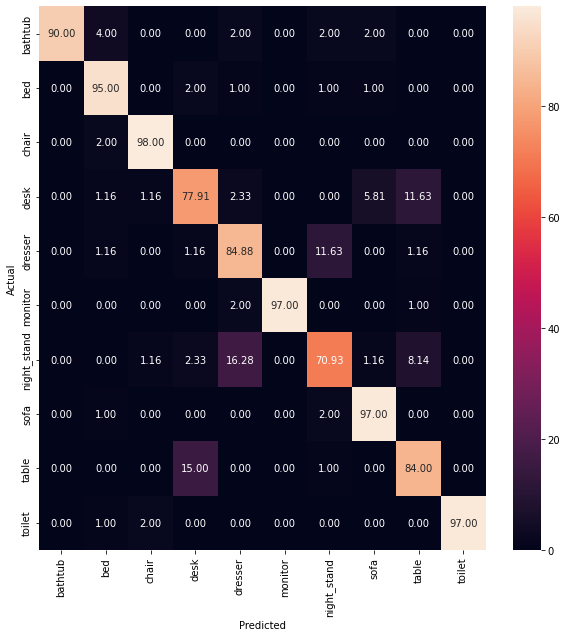

In [668]:
cm = confusion_matrix(test_labels, y_pred_actual)

cm = ((cm.astype(float) / cm.sum(axis=1)[:, np.newaxis])*100)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('images/confusion_matrix.png')
plt.show(block=False)

#### Save the model

In [669]:
modelID = "saves/896Acc"
model.save(modelID + ".h5")
np.save(modelID + '_train_final.npy', train_final)
np.save(modelID + '_test_final.npy', test_final)
np.save(modelID + '_train_labels.npy', train_labels)
np.save(modelID + '_test_labels.npy', test_labels)

#### Load the model

In [ ]:
modelID = "saves/896Acc"
model = keras.models.load_model(modelID + ".h5")
train_final = np.load(modelID + '_train_final.npy')
test_final = np.load(modelID + '_test_final.npy')
train_labels = np.load(modelID + '_train_labels.npy')
test_labels = np.load(modelID + '_test_labels.npy')

In [7]:
tf.config.list_physical_devices('GPU')

[]